# Genetic Algorithm base
(largely copied from JMetalPy framework: https://github.com/jMetal/jMetalPy)

## Individual encoding

In [1]:
import numpy as np
import random

from typing import List, Union


class Individual:
    """ Class representing individual """

    def __init__(self, number_of_variables: int, number_of_objectives: int, lower_bound: List[float], upper_bound: List[float]):
        self.number_of_variables = number_of_variables
        self.number_of_objectives = number_of_objectives
        
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
        self.variables = self._init_variables()
        self.objectives = np.zeros(number_of_objectives)
        
        self.attributes = {}
        
    def _init_variables(self) -> np.array:
        variables = np.zeros(self.number_of_variables)
        for i in range(self.number_of_variables):
            variables[i] = random.uniform(self.lower_bound[i], self.upper_bound[i])
        return variables

    def __eq__(self, other) -> bool:
        if isinstance(other, self.__class__):
            return self.variables == other.variables
        return False
    
    def __str__(self):
        return f'Objectives: {self.objectives}'

## Genetic operators

### Abstract

In [2]:
from abc import abstractmethod


class Operator:
    """ Class representing operator """

    @abstractmethod
    def execute(self, source):
        pass

    @abstractmethod
    def get_name(self) -> str:
        pass


def check_valid_probability_value(func):
    def func_wrapper(self, probability: float):
        if probability > 1.0:
            raise Exception('The probability is greater than one: {}'.format(probability))
        elif probability < 0.0:
            raise Exception('The probability is lower than zero: {}'.format(probability))

        res = func(self, probability)
        return res
    return func_wrapper


class Mutation(Operator):
    """ Class representing mutation operator. """

    @check_valid_probability_value
    def __init__(self, probability: float):
        self.probability = probability


class Crossover(Operator):
    """ Class representing crossover operator. """

    @check_valid_probability_value
    def __init__(self, probability: float):
        self.probability = probability

    @abstractmethod
    def get_number_of_parents(self) -> int:
        pass

    @abstractmethod
    def get_number_of_children(self) -> int:
        pass


class Selection(Operator):
    """ Class representing selection operator. """

    def __init__(self):
        pass


### SBX Crossover

In [3]:
from copy import deepcopy


class SBXCrossover:
    __EPS = 1.0e-14

    def __init__(self, probability: float, distribution_index: float = 20.0):
        self.probability = probability
        self.distribution_index = distribution_index
        if distribution_index < 0:
            raise Exception(f"The distribution index is negative: {distribution_index}")

    def execute(self, parents: List[Individual]) -> List[Individual]:
        assert len(parents) == 2, f"The number of parents is not two: {len(parents)}"

        number_of_variables = parents[0].number_of_variables
        offspring = [deepcopy(parents[0]), deepcopy(parents[1])]

        if random.random() <= self.probability:
            for i in range(number_of_variables):
                value_x1, value_x2 = parents[0].variables[i], parents[1].variables[i]

                if random.random() <= 0.5:
                    if abs(value_x1 - value_x2) > self.__EPS:
                        if value_x1 < value_x2:
                            y1, y2 = value_x1, value_x2
                        else:
                            y1, y2 = value_x2, value_x1

                        lower_bound, upper_bound = (
                            parents[0].lower_bound[i],
                            parents[1].upper_bound[i],
                        )

                        beta = 1.0 + (2.0 * (y1 - lower_bound) / (y2 - y1))
                        alpha = 2.0 - pow(beta, -(self.distribution_index + 1.0))

                        rand = random.random()
                        if rand <= (1.0 / alpha):
                            betaq = pow(
                                rand * alpha, (1.0 / (self.distribution_index + 1.0))
                            )
                        else:
                            betaq = pow(
                                1.0 / (2.0 - rand * alpha),
                                1.0 / (self.distribution_index + 1.0),
                            )

                        c1 = 0.5 * (y1 + y2 - betaq * (y2 - y1))
                        beta = 1.0 + (2.0 * (upper_bound - y2) / (y2 - y1))
                        alpha = 2.0 - pow(beta, -(self.distribution_index + 1.0))

                        if rand <= (1.0 / alpha):
                            betaq = pow(
                                (rand * alpha), (1.0 / (self.distribution_index + 1.0))
                            )
                        else:
                            betaq = pow(
                                1.0 / (2.0 - rand * alpha),
                                1.0 / (self.distribution_index + 1.0),
                            )

                        c2 = 0.5 * (y1 + y2 + betaq * (y2 - y1))

                        if c1 < lower_bound:
                            c1 = lower_bound
                        if c2 < lower_bound:
                            c2 = lower_bound
                        if c1 > upper_bound:
                            c1 = upper_bound
                        if c2 > upper_bound:
                            c2 = upper_bound

                        if random.random() <= 0.5:
                            offspring[0].variables[i] = c2
                            offspring[1].variables[i] = c1
                        else:
                            offspring[0].variables[i] = c1
                            offspring[1].variables[i] = c2
                    else:
                        offspring[0].variables[i] = value_x1
                        offspring[1].variables[i] = value_x2
                else:
                    offspring[0].variables[i] = value_x1
                    offspring[1].variables[i] = value_x2
        return offspring

    def get_number_of_parents(self) -> int:
        return 2

    def get_number_of_children(self) -> int:
        return 2

    def get_name(self) -> str:
        return "SBX crossover"

### Polynomial Mutation

In [4]:
class PolynomialMutation:

    def __init__(self, probability: float, distribution_index: float = 0.20):
        self.probability = probability
        self.distribution_index = distribution_index

    def execute(self, individual: Individual) -> Individual:
        for i in range(individual.number_of_variables):
            rand = random.random()

            if rand <= self.probability:
                y = individual.variables[i]
                yl, yu = individual.lower_bound[i], individual.upper_bound[i]

                if yl == yu:
                    y = yl
                else:
                    delta1 = (y - yl) / (yu - yl)
                    delta2 = (yu - y) / (yu - yl)
                    rnd = random.random()
                    mut_pow = 1.0 / (self.distribution_index + 1.0)
                    if rnd <= 0.5:
                        xy = 1.0 - delta1
                        val = 2.0 * rnd + (1.0 - 2.0 * rnd) * (pow(xy, self.distribution_index + 1.0))
                        deltaq = pow(val, mut_pow) - 1.0
                    else:
                        xy = 1.0 - delta2
                        val = 2.0 * (1.0 - rnd) + 2.0 * (rnd - 0.5) * (pow(xy, self.distribution_index + 1.0))
                        deltaq = 1.0 - pow(val, mut_pow)

                    y += deltaq * (yu - yl)
                    if y < individual.lower_bound[i]:
                        y = individual.lower_bound[i]
                    if y > individual.upper_bound[i]:
                        y = individual.upper_bound[i]

                individual.variables[i] = y

        return individual

    def get_name(self):
        return 'Polynomial mutation'

### Comparator

In [5]:
def dominance_test(solution1: Individual, solution2: Individual) -> int:
    best_is_one = 0
    best_is_two = 0

    for i in range(solution1.number_of_objectives):
        value1 = solution1.objectives[i]
        value2 = solution2.objectives[i]
        if value1 != value2:
            if value1 < value2:
                best_is_one = 1
            if value1 > value2:
                best_is_two = 1

    if best_is_one > best_is_two:
        result = -1
    elif best_is_two > best_is_one:
        result = 1
    else:
        result = 0

    return result


class AttributeComparator:
    def __init__(self, key, lowest_is_best=True):
        self.key = key
        self.lowest_is_best = lowest_is_best

    def compare(self, solution1: Individual, solution2: Individual):
        value1 = solution1.attributes[self.key]
        value2 = solution2.attributes[self.key]

        result = 0
        if value1 is not None and value2 is not None:
            if self.lowest_is_best:
                if value1 < value2:
                    result = -1
                elif value1 > value2:
                    result = 1
                else:
                    result = 0
            else:
                if value1 > value2:
                    result = -1
                elif value1 < value2:
                    result = 1
                else:
                    result = 0

        return result

### Selection

In [6]:
class BinaryTournamentSelection:
    def execute(self, front: List[Individual]) -> Individual:
        if front is None:
            raise Exception("The front is null")
        elif len(front) == 0:
            raise Exception("The front is empty")

        if len(front) == 1:
            result = front[0]
        else:
            # Sampling without replacement
            i, j = random.sample(range(0, len(front)), 2)
            solution1 = front[i]
            solution2 = front[j]

            flag = dominance_test(solution1, solution2)

            if flag == -1:
                result = solution1
            elif flag == 1:
                result = solution2
            else:
                result = [solution1, solution2][random.random() < 0.5]

        return result

    def get_name(self):
        return "Binary Tournament Selection"

## Abstract problem class

In [7]:
from abc import abstractmethod


class Problem:
    """ Class representing problems. """

    MINIMIZE = -1
    MAXIMIZE = 1

    def __init__(self):
        self.number_of_variables: int = 0
        self.number_of_objectives: int = 0

        self.reference_front: List[Individual] = []

        self.directions: List[int] = []
        self.labels: List[str] = []

        self.lower_bound = []
        self.upper_bound = []

    def create_solution(self) -> Individual:
        """ Creates a random_search solution to the problem. """
        return Individual(
            self.number_of_variables,
            self.number_of_objectives,
            self.lower_bound,
            self.upper_bound,
        )

    @abstractmethod
    def evaluate(self, individual: Individual) -> Individual:
        """ Evaluate a solution. For any new problem inheriting from :class:`Problem`, this method should be
        replaced. Note that this framework ASSUMES minimization, thus solutions must be evaluated in consequence.
        :return: Evaluated solution. """
        pass

    @abstractmethod
    def get_name(self) -> str:
        pass

## IGD Metrics

<img src='igd.png'>

In [8]:
from scipy import spatial


def read_reference_points(filepath: str):
    return np.loadtxt(filepath)


class InvertedGenerationalDistance:
    def __init__(self, reference_front: np.array):
        self.reference_front = reference_front

    def compute(self, population: List[Individual]):
        if self.reference_front is None:
            raise Exception('Reference front is none')
            
        objectives = tuple(individual.objectives for individual in population)
        objectives = np.vstack(objectives)

        distances = spatial.distance.cdist(self.reference_front, objectives)

        return np.mean(np.min(distances, axis=1))

    def get_short_name(self) -> str:
        return 'IGD'

    def get_name(self) -> str:
        return 'Inverted Generational Distance'


## Algorithm implementation

### Fast Non-dominated Ranking

In [9]:
def compute_ranking(population: List[Individual]) -> List[Individual]:
    """ 
    (Copy paste)
    Compute ranking of solutions.
    :param population: list of individuals.
    :param k: Number of individuals.
    """
    # number of solutions dominating solution ith
    dominating_ith = [0 for _ in range(len(population))]

    # list of solutions dominated by solution ith
    ith_dominated = [[] for _ in range(len(population))]

    # front[i] contains the list of solutions belonging to front i
    front = [[] for _ in range(len(population) + 1)]

    for p in range(len(population) - 1):
        for q in range(p + 1, len(population)):
            dominance_test_result = dominance_test(population[p], population[q])

            if dominance_test_result == -1:
                ith_dominated[p].append(q)
                dominating_ith[q] += 1
            elif dominance_test_result is 1:
                ith_dominated[q].append(p)
                dominating_ith[p] += 1

    for i in range(len(population)):
        if dominating_ith[i] is 0:
            front[0].append(i)
            population[i].attributes["dominance_ranking"] = 0

    i = 0
    while len(front[i]) != 0:
        i += 1
        for p in front[i - 1]:
            if p <= len(ith_dominated):
                for q in ith_dominated[p]:
                    dominating_ith[q] -= 1
                    if dominating_ith[q] is 0:
                        front[i].append(q)
                        population[q].attributes["dominance_ranking"] = i

    ranked_sublists = [[]] * i
    for j in range(i):
        q = [0] * len(front[j])
        for m in range(len(front[j])):
            q[m] = population[front[j][m]]
        ranked_sublists[j] = q

    return ranked_sublists

### Crowding Distance

In [10]:
from functools import cmp_to_key


class CrowdingDistance:
    """
    This class implements a DensityEstimator based on the crowding distance of algorithm NSGA-II.
    """

    @staticmethod
    def compute_density_estimator(front: List[Individual]):
        """This function performs the computation of the crowding density estimation over the solution list.
        .. note::
           This method assign the distance in the inner elements of the solution list.
        :param front: The list of solutions.
        """
        size = len(front)

        if size is 0:
            return
        elif size is 1:
            front[0].attributes["crowding_distance"] = float("inf")
            return
        elif size is 2:
            front[0].attributes["crowding_distance"] = float("inf")
            front[1].attributes["crowding_distance"] = float("inf")
            return

        for i in range(len(front)):
            front[i].attributes["crowding_distance"] = 0.0

        number_of_objectives = front[0].number_of_objectives

        for i in range(number_of_objectives):
            # Sort the population by Obj n
            front = sorted(front, key=lambda x: x.objectives[i])
            objective_minn = front[0].objectives[i]
            objective_maxn = front[len(front) - 1].objectives[i]

            # Set the crowding distance
            front[0].attributes["crowding_distance"] = float("inf")
            front[size - 1].attributes["crowding_distance"] = float("inf")

            for j in range(1, size - 1):
                distance = front[j + 1].objectives[i] - front[j - 1].objectives[i]

                # Check if minimum and maximum are the same (in which case do nothing)
                if objective_maxn - objective_minn == 0:
                    pass
                    # LOGGER.warning('Minimum and maximum are the same!')
                else:
                    distance = distance / (objective_maxn - objective_minn)

                distance += front[j].attributes["crowding_distance"]
                front[j].attributes["crowding_distance"] = distance

    @staticmethod
    def sort(population: List[Individual]) -> List[Individual]:
        comparator = AttributeComparator("crowding_distance", lowest_is_best=False)
        population.sort(key=cmp_to_key(comparator.compare))

### NSGA II

In [11]:
def truncation(
    ranked_joint_population: List[List[Individual]],
    rank_id: int,
    remaining_population_size: int,
) -> List[Individual]:

    current_ranked_population = ranked_joint_population[rank_id]
    CrowdingDistance.compute_density_estimator(current_ranked_population)

    result_list: List[Individual] = []

    if len(current_ranked_population) < remaining_population_size:
        result_list.extend(current_ranked_population)
        result_list.extend(
            truncation(
                ranked_joint_population,
                rank_id + 1,
                remaining_population_size - len(current_ranked_population),
            )
        )
    else:
        CrowdingDistance.sort(current_ranked_population)
        i = 0
        while len(result_list) < remaining_population_size:
            result_list.append(current_ranked_population[i])
            i += 1

    return result_list

In [12]:
import time
from tqdm.auto import tqdm


class NSGAII:
    def __init__(
        self,
        problem: Problem,
        population_size: int,
        crossover_operator: Crossover,
        mutation_operator: Mutation,
        selection_operator: Selection,
        max_generation_loops: int = 100,
        reference_filepath: Union[str, None] = None,
    ):
        self.max_generation_loops = max_generation_loops
        self.start_computing_time = 0
        self.total_computing_time = 0

        self.problem = problem
        self.population_size = population_size
        self.population: List[Individual] = []
        self.mating_pool_size = population_size
        self.offspring_population_size = population_size

        self.crossover_operator = crossover_operator
        self.mutation_operator = mutation_operator
        self.selection_operator = selection_operator
        
        self.igd = None
        if reference_filepath:
            reference_front = read_reference_points(reference_filepath)
            self.igd = InvertedGenerationalDistance(reference_front)

    def create_initial_population(self) -> List[Individual]:
        return [self.problem.create_solution() for _ in range(self.population_size)]

    def evaluate(self, population: List[Individual]) -> List[Individual]:
        """ Evaluates a set of population. """
        evaluated_population = [
            self.problem.evaluate(individual) for individual in population
        ]
        return evaluated_population

    def selection(self, population: List[Individual]):
        mating_population = []

        for i in range(self.mating_pool_size):
            individual = self.selection_operator.execute(population)
            mating_population.append(individual)

        return mating_population

    def reproduction(self, mating_population: List[Individual]) -> List[Individual]:
        number_of_parents_to_combine = self.crossover_operator.get_number_of_parents()

        if len(mating_population) % number_of_parents_to_combine != 0:
            raise Exception("Wrong number of parents")

        offspring_population = []
        for i in range(0, self.offspring_population_size, number_of_parents_to_combine):
            parents = []
            for j in range(number_of_parents_to_combine):
                parents.append(mating_population[i + j])

            offspring = self.crossover_operator.execute(parents)

            for solution in offspring:
                self.mutation_operator.execute(solution)
                offspring_population.append(solution)
                if len(offspring_population) >= self.offspring_population_size:
                    break

        return offspring_population

    def replacement(
        self, population: List[Individual], offspring_population: List[Individual]
    ) -> List[List[Individual]]:
        ranked_joint_population = compute_ranking(population + offspring_population)
        new_population = truncation(ranked_joint_population, 0, self.population_size)

        return new_population

    def step(self) -> None:
        mating_population = self.selection(self.population)
        offspring_population = self.reproduction(mating_population)
        offspring_population = self.evaluate(offspring_population)

        self.population = self.replacement(self.population, offspring_population)

    def run(self):
        """ Execute the algorithm. """
        self.start_computing_time = time.time()

        self.population = self.create_initial_population()
        self.population = self.evaluate(self.population)
        pbar = tqdm(range(self.max_generation_loops))
        for loop in pbar:
            igd = None
            if self.igd:
                igd = self.igd.compute(self.get_result())
                pbar.set_description(f'IGD {igd:.6f}')
            self.step()

        self.total_computing_time = time.time() - self.start_computing_time

    def get_result(self) -> List[Individual]:
        return self.population

    def get_name(self) -> str:
        return "NSGAII"

# Sample Problem

## ZDT-1 problem


<img src="zdt1.png">

<img src="zdt1-ref-front.jpg">

In [13]:
class ZDT1(Problem):
    """ Problem ZDT1.
    .. note:: Bi-objective unconstrained problem. The default number of variables is 30.
    .. note:: Continuous problem having a convex Pareto front
    """

    def __init__(self, number_of_variables: int=30):
        """ :param number_of_variables: Number of decision variables of the problem.
        """
        super(ZDT1, self).__init__()
        self.number_of_variables = number_of_variables
        self.number_of_objectives = 2
        self.number_of_constraints = 0

        self.directions = [self.MINIMIZE, self.MINIMIZE]
        self.labels = ['x', 'y']

        self.lower_bound = self.number_of_variables * [0.0]
        self.upper_bound = self.number_of_variables * [1.0]

    def evaluate(self, solution: Individual) -> Individual:
        g = self.eval_g(solution)
        h = self.eval_h(solution.variables[0], g)

        solution.objectives[0] = solution.variables[0]
        solution.objectives[1] = h * g

        return solution

    def eval_g(self, solution: Individual):
        g = np.sum(solution.variables) - solution.variables[0]

        constant = 9.0 / (solution.number_of_variables - 1)

        return constant * g + 1.0

    def eval_h(self, f: float, g: float) -> float:
        return 1.0 - np.sqrt(f / g)

    def get_name(self):
        return 'ZDT1'


## Experiment

In [14]:
population_size = 100
algorithm = NSGAII(
    ZDT1(),
    population_size,
    SBXCrossover(0.9),
    PolynomialMutation(1.0 / population_size),
    BinaryTournamentSelection(),
    max_generation_loops=200,
    reference_filepath='ZDT1.pf'
)
algorithm.run()
result = algorithm.get_result()

In [15]:
front = compute_ranking(result)[0]
print(front[0])

Objectives: [4.79485217e-07 1.00936419e+00]


## Plot

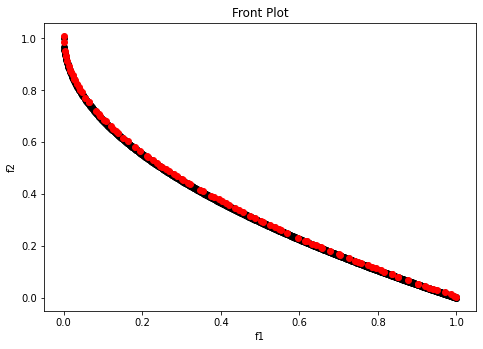

In [16]:
import matplotlib.pyplot as plt

def visualize_front(front, reference_front=None):
    fig = plt.figure()
    ax= fig.add_axes([0,0,1,1])

    f1 = [solution.objectives[0] for solution in front]
    f2 = [solution.objectives[1] for solution in front]    
 
    if reference_front is not None:
        ax.scatter(reference_front[:, 0], reference_front[:, 1], color='black')
    ax.scatter(f1, f2, color='r')
    
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    ax.set_title('Front Plot')
    
visualize_front(front, read_reference_points('ZDT1.pf'))

# Playground
Implement ZDT-3 benchmark problem

<img src="zdt3.png">

<img src="zdt3-ref-front.jpg">